In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pickle
import torch
import sys
import os
sys.path.append("../")
import time
import numpy as np


/compuworks/anaconda3/envs/infGCN/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# batch_data = pickle.load(open('batch_data_train.pkl', 'rb'))
batch_data = pickle.load(open('mp_batch_data_for_unit_test.pkl', 'rb'))
g, densities, grid_coord, infos = batch_data
batch_data = {
    'atom_types': g.x,
    'atom_coord': g.pos,
    'grid': grid_coord,
    'batch': g.batch,
    'targets': densities,
    'infos': infos
}

In [4]:
for i, info in enumerate(batch_data["infos"]):
    print(f"{i}: {info['file_name']}")

0: mp-979413.chgcar
1: mp-677095.chgcar
2: mp-30510.chgcar
3: mp-1219846.chgcar
4: mp-974432.chgcar
5: mp-1212052.chgcar
6: mp-1039794.chgcar
7: mp-567499.chgcar
8: mp-1047437.chgcar
9: mp-972202.chgcar
10: mp-622018.chgcar
11: mp-1185464.chgcar
12: mp-1209644.chgcar
13: mp-1038594.chgcar
14: mp-1180386.chgcar
15: mp-1209820.chgcar
16: mp-1414188.chgcar
17: mp-5919.chgcar
18: mp-1216550.chgcar
19: mp-10287.chgcar
20: mp-22383.chgcar
21: mp-1218815.chgcar
22: mp-752420.chgcar
23: mp-1186512.chgcar
24: mp-1222421.chgcar
25: mp-1228343.chgcar
26: mp-1226874.chgcar
27: mp-1135.chgcar
28: mp-1025119.chgcar
29: mp-1222993.chgcar
30: mp-20737.chgcar
31: mp-1188110.chgcar


In [5]:
# we will use 12th file, SmIn2Cu9, Site 24, Tetrganoal

In [6]:
batch_data.keys()

dict_keys(['atom_types', 'atom_coord', 'grid', 'batch', 'targets', 'infos'])

In [7]:
atom_types = batch_data["atom_types"]
atom_coord = batch_data["atom_coord"]
grid = batch_data["grid"]
batch = batch_data["batch"]
infos = batch_data["infos"]
targets = batch_data["targets"]

In [8]:
# Refine to 12th file
idx = 12
atom_types = atom_types[batch==idx]
atom_coord = atom_coord[batch==idx]
infos = [infos[idx]]
batch = batch[batch==idx]
batch[batch==idx] = 0
target = targets[idx].unsqueeze(0)
grid = grid[idx].unsqueeze(0)

In [9]:
# test_cell = torch.tensor([[1,0,0.1], [0,1,0], [0.1,0,1]], dtype=torch.float32)
# test_coord = torch.tensor([[0.25, 0.25, 0.25],[0.5,0.25,0.25]], dtype=torch.float32)
# test_batch = torch.tensor([0,0], dtype=torch.int64)
# test_type = torch.tensor([1,2], dtype=torch.int64)

In [10]:
def make_supercell(atom_types, atom_coord, batch, infos, supercell_idx = [1,1,1]):
    cell = infos[0]["cell"]
    supercell_idx = torch.tensor(supercell_idx)
    supercell = torch.einsum("i,ij->ij", supercell_idx.float().to(cell.device),cell)
    super_coords = []
    super_types = []
    for i in range(supercell_idx[0]):
        for j in range(supercell_idx[1]):
            for k in range(supercell_idx[2]):
                super_coords.append(atom_coord + i*cell[0] + j*cell[1] + k*cell[2])
                super_types.append(atom_types)
    
    super_types = torch.cat(super_types, dim=0).to(atom_types.device)
    super_coords = torch.cat(super_coords, dim=0).to(atom_coord.device)
    super_batch = torch.zeros_like(super_types).to(atom_types.device)
    super_infos = infos[0].copy()
    super_infos["cell"] = supercell
    print("number of atoms",len(super_types))
    print("original cell\n", cell)
    print("supercell\n", supercell)
    print("supercell_idx\n", supercell_idx)
    return super_types, super_coords, super_batch, [super_infos]

In [11]:
from source.models.GPWNO_test import GPWNO
from source.baseline.infgcn import InfGCN

In [12]:
model1 = GPWNO(
    n_atom_type=85,
    num_radial=16,
    num_spherical=3,
    radial_embed_size=64,
    radial_hidden_size=128,
    num_radial_layer=2,
    num_gcn_layer=2,
    cutoff=3.0,
    is_fc=False,
    gauss_start=0.5,
    gauss_end=5.,
    residual=True,
    pbc=True,
    activation="norm",
    num_fourier=20,
    num_fourier_time=12,
    width=16,
    fourier_mode=0,
    padding=0,
    use_max_cell=False,
    equivariant_frame=False,
    probe_cutoff=1.5,
    grid_cutoff=0.75,
    normalize=True,
    using_ff=True,
    model_sharing=False,
    num_infgcn_layer=3,
    use_detach=False,
    num_spherical_RNO=3,
    scalar_mask=True,
    mask_cutoff=1.0,
    input_infgcn=False,
    output_positive=False,
    atom_info="/home/holywater2/crystal/GPWNO/atom_info/mp_tetragonal_atom_info.json",
    input_dist=False,
    atomic_gauss_dist=False
).cuda()

/compuworks/anaconda3/envs/infGCN/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
/compuworks/anaconda3/envs/infGCN/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


In [13]:
# model2 = InfGCN(
#     n_atom_type=85,
#     num_radial=16,
#     num_spherical=7,
#     radial_embed_size=64,
#     radial_hidden_size=128,
#     num_radial_layer=2,
#     num_gcn_layer=3,
#     cutoff=5.0,
#     is_fc=False,
#     gauss_start=0.5,
#     gauss_end=5.,
#     residual=False,
#     pbc=True,
#     activation="norm",    
# ).cuda()

In [14]:
# model3 = InfGCN(
#     n_atom_type=85,
#     num_radial=16,
#     num_spherical=3,
#     radial_embed_size=64,
#     radial_hidden_size=128,
#     num_radial_layer=2,
#     num_gcn_layer=3,
#     cutoff=5.0,
#     is_fc=False,
#     gauss_start=0.5,
#     gauss_end=5.,
#     residual=False,
#     pbc=True,
#     activation="norm",    
# ).cuda()

In [15]:
def time_stats(model, atom_types, atom_coord, grid, batch,infos, supercell_idx =[1,1,1],num_iter=100,model_type="GPWNO"):
    at, ac, b, ifs = make_supercell(atom_types, atom_coord, batch, infos, supercell_idx)
    g = grid
    t = 0
    probe_degree = 0
    start_time = time.time()
    with torch.no_grad():
        for i in range(num_iter):
            dd = model.forward(at, ac, g, b, ifs)
            if type == "GPWNO":
                t += dd["time"]
            
    end_time = time.time()
    runtime = end_time - start_time
    print("total runtime     :",runtime, runtime/num_iter)
    # if model_type == "GPWNO":
    #     print("runtime w/o radius:",runtime - t, (runtime - t)/num_iter)
    #     print("probe degree      :",dd["avg_probe_degree"])
    #     print("sample degree     :",dd["avg_sample_degree"])
    #     print("probe exist rate  :",dd["avg_probe_exist_rate"])
    #     print("probe exist degr  :",dd["avg_probe_exist_degree"])
    del at, ac, b, ifs, dd
    return len(atom_types), runtime

In [16]:
from torch_geometric.data.batch import DataBatch

def time_stats_train(model, atom_types, atom_coord, grid, batch,infos, target, supercell_idx =[1,1,1],num_iter=100,model_type="GPWNO"):
    print("mode: train")
    at, ac, b, ifs = make_supercell(atom_types, atom_coord, batch, infos, supercell_idx)
    g = grid
    t = 0
    probe_degree = 0
    databatch = DataBatch(x=at, pos=ac, batch=b)
    # print(databatch)
    start_time = time.time()
    for i in range(num_iter):
        dd = model.training_step([databatch,target,g,ifs],0)
        dd.backward()
        if type == "GPWNO":
            t += dd["time"]
            
    end_time = time.time()
    runtime = end_time - start_time
    print("total runtime     :",runtime, runtime/num_iter)
    del at, ac, b, ifs, dd
    return len(atom_types), runtime

In [17]:
res_test = np.zeros((10,5))
for i in range(5):
    res = np.zeros((10))
    res[0] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [1,1,1],num_iter=2)[1]
    res[1] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [2,1,1],num_iter=2)[1]
    res[2] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [2,2,1],num_iter=2)[1]
    res[3] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [2,2,2],num_iter=2)[1]
    res[4] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [3,2,2],num_iter=2)[1]
    res[5] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [3,3,3],num_iter=2)[1]
    res[6] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [4,3,3],num_iter=2)[1]
    res[7] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [5,3,3],num_iter=2)[1]
    res[8] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [5,4,3],num_iter=2)[1]
    res[9] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [4,4,4],num_iter=2)[1]
    res_test[:,i] = res

res_test.mean(axis=1), res_test.std(axis=1)

mode: train
number of atoms 24
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell_idx
 tensor([1, 1, 1])


/compuworks/anaconda3/envs/infGCN/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/compuworks/anaconda3/envs/infGCN/lib/python3.9/site-packages/pytorch_lightning/core/module.py:420: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


total runtime     : 9.7634859085083 4.88174295425415
mode: train
number of atoms 48
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [ 8.4651,  0.0000,  0.0000],
        [ 0.0000,  8.4651,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 1, 1])
total runtime     : 3.685042381286621 1.8425211906433105
mode: train
number of atoms 96
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000,  8.4651,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 2, 1])
total runtime     : 0.21339702606201172 0.10669851303100586
mode: train
number of atoms 192
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], de

(array([2.23833895, 0.88954573, 0.19705997, 0.24412274, 0.20444412,
        0.23319321, 0.25266757, 0.26226425, 0.72267599, 0.35579624]),
 array([3.77103849e+00, 1.39776090e+00, 1.19921401e-02, 9.27402762e-02,
        6.15792319e-03, 1.00484010e-02, 2.77441552e-03, 2.50781508e-03,
        8.44279944e-01, 8.95641127e-02]))

In [18]:
res_train = np.zeros((11,5))
for i in range(5):
    res = np.zeros((11))
    res[0] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [1,1,1],num_iter=100)[1]
    res[1] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [2,1,1],num_iter=100)[1]
    res[2] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [2,2,1],num_iter=100)[1]
    res[3] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [2,2,2],num_iter=100)[1]
    res[4] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [3,2,2],num_iter=100)[1]
    res[5] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [3,3,2],num_iter=100)[1]
    res[6] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [3,3,3],num_iter=100)[1]
    res[7] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [4,3,3],num_iter=100)[1]
    res[8] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [5,3,3],num_iter=100)[1]
    res[9] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [5,4,3],num_iter=100)[1]
    res[10] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [4,4,4],num_iter=100)[1]
    res_train[:,i] = res

res_train.mean(axis=1), res_train.std(axis=1)

mode: train
number of atoms 24
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell_idx
 tensor([1, 1, 1])
total runtime     : 9.805772066116333 0.09805772066116333
mode: train
number of atoms 48
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [ 8.4651,  0.0000,  0.0000],
        [ 0.0000,  8.4651,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 1, 1])
total runtime     : 9.794307708740234 0.09794307708740234
mode: train
number of atoms 96
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
 

(array([ 9.41283927,  9.42200847,  9.62338905,  9.86146712, 10.08461485,
        10.55989676, 11.37272296, 12.07353735, 12.89772525, 14.84813652,
        15.41807632]),
 array([0.3484338 , 0.32822858, 0.34911897, 0.35181976, 0.32831675,
        0.24031248, 0.23576433, 0.21465558, 0.22938474, 0.34212269,
        0.4312769 ]))

In [19]:
res_inf = np.zeros((11,5))
for i in range(5):
    res = np.zeros((11))
    res[0] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [1,1,1],num_iter=100)[1]
    res[1] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [2,1,1],num_iter=100)[1]
    res[2] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [2,2,1],num_iter=100)[1]
    res[3] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [2,2,2],num_iter=100)[1]
    res[4] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [3,2,2],num_iter=100)[1]
    res[5] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [3,3,2],num_iter=100)[1]
    res[6] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [3,3,3],num_iter=100)[1]
    res[7] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [4,3,3],num_iter=100)[1]
    res[8] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [5,3,3],num_iter=100)[1]
    res[9] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [5,4,3],num_iter=100)[1]
    res[10] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [4,4,4],num_iter=100)[1]
    res_inf[:,i] = res

res_inf.mean(axis=1), res_inf.std(axis=1)

number of atoms 24
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell_idx
 tensor([1, 1, 1])
total runtime     : 4.4297380447387695 0.044297380447387694
number of atoms 48
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [ 8.4651,  0.0000,  0.0000],
        [ 0.0000,  8.4651,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 1, 1])


total runtime     : 4.438055515289307 0.04438055515289307
number of atoms 96
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000,  8.4651,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 2, 1])
total runtime     : 4.595529317855835 0.04595529317855835
number of atoms 192
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000, 16.9302,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 2, 2])
total runtime     : 4.854482889175415 0.04854482889175415
number of atoms 288
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tenso

(array([4.36091294, 4.39767122, 4.55270014, 4.9220593 , 5.21261468,
        5.69175453, 6.41281495, 7.15651202, 7.9003335 , 9.18077722,
        9.5385911 ]),
 array([0.04718561, 0.05090977, 0.02920668, 0.07223462, 0.04161857,
        0.05661053, 0.02275017, 0.03769986, 0.06110329, 0.03879361,
        0.04401649]))

In [20]:
res_train = np.zeros((10,5))
for i in range(5):
    res = np.zeros((10))
    res[0] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [1,1,1],num_iter=100)[1]
    res[1] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [2,1,1],num_iter=100)[1]
    res[2] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [2,2,1],num_iter=100)[1]
    res[3] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [2,2,2],num_iter=100)[1]
    res[4] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [3,2,2],num_iter=100)[1]
    res[5] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [3,3,3],num_iter=100)[1]
    res[6] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [4,3,3],num_iter=100)[1]
    res[7] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [5,3,3],num_iter=100)[1]
    res[8] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [5,4,3],num_iter=100)[1]
    res[9] += time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [4,4,4],num_iter=100)[1]
    res_train[:,i] = res

res_train.mean(axis=1), res_train.std(axis=1)

mode: train
number of atoms 24
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell_idx
 tensor([1, 1, 1])
total runtime     : 8.925883054733276 0.08925883054733276
mode: train
number of atoms 48
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [ 8.4651,  0.0000,  0.0000],
        [ 0.0000,  8.4651,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 1, 1])
total runtime     : 9.469236135482788 0.09469236135482788
mode: train
number of atoms 96
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
 

(array([ 9.06935019,  9.30263972,  9.5822722 ,  9.87302747, 10.09427252,
        11.28778882, 11.88668547, 12.76131024, 14.64883623, 15.38524232]),
 array([0.14625141, 0.09150627, 0.21698079, 0.37167447, 0.27924806,
        0.28453122, 0.13929103, 0.21033422, 0.01394389, 0.11506853]))

In [21]:
res_inf = np.zeros((10,5))
for i in range(5):
    res = np.zeros((10))
    res[0] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [1,1,1],num_iter=100)[1]
    res[1] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [2,1,1],num_iter=100)[1]
    res[2] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [2,2,1],num_iter=100)[1]
    res[3] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [2,2,2],num_iter=100)[1]
    res[4] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [3,2,2],num_iter=100)[1]
    res[5] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [3,3,3],num_iter=100)[1]
    res[6] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [4,3,3],num_iter=100)[1]
    res[7] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [5,3,3],num_iter=100)[1]
    res[8] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [5,4,3],num_iter=100)[1]
    res[9] += time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [4,4,4],num_iter=100)[1]
    res_inf[:,i] = res

res_inf.mean(axis=1), res_inf.std(axis=1)

number of atoms 24
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell_idx
 tensor([1, 1, 1])
total runtime     : 4.301855564117432 0.043018555641174315
number of atoms 48
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [ 8.4651,  0.0000,  0.0000],
        [ 0.0000,  8.4651,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 1, 1])
total runtime     : 4.422361373901367 0.04422361373901367
number of atoms 96
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [16.9302,  0.0000,  0.0000],

(array([4.35170617, 4.39902148, 4.58299465, 4.8772007 , 5.22069864,
        6.52586322, 7.15871973, 7.96305952, 9.24761968, 9.5874969 ]),
 array([0.04658503, 0.07027702, 0.05379514, 0.06038169, 0.07990064,
        0.07778026, 0.03505626, 0.07024335, 0.05418917, 0.03729432]))

In [18]:
time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [1,1,1],num_iter=100)

mode: train
number of atoms 24
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell_idx
 tensor([1, 1, 1])
total runtime     : 12.839256525039673 0.12839256525039672


(24, 12.839256525039673)

In [19]:
time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [2,1,1],num_iter=100)

mode: train
number of atoms 48
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [ 8.4651,  0.0000,  0.0000],
        [ 0.0000,  8.4651,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 1, 1])


total runtime     : 10.728673219680786 0.10728673219680786


(24, 10.728673219680786)

In [20]:
time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [2,2,1],num_iter=100)

mode: train
number of atoms 96
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000,  8.4651,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 2, 1])
total runtime     : 9.179097414016724 0.09179097414016724


(24, 9.179097414016724)

In [21]:
time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [2,2,2],num_iter=100)

mode: train
number of atoms 192
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000, 16.9302,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 2, 2])
total runtime     : 9.034868478775024 0.09034868478775024


(24, 9.034868478775024)

In [22]:
time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [3,2,2],num_iter=100)

mode: train
number of atoms 288
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 15.0708],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000, 16.9302,  0.0000]], device='cuda:0')
supercell_idx
 tensor([3, 2, 2])
total runtime     : 10.912938117980957 0.10912938117980957


(24, 10.912938117980957)

In [23]:
time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [3,3,3],num_iter=100)

mode: train
number of atoms 648
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 15.0708],
        [25.3953,  0.0000,  0.0000],
        [ 0.0000, 25.3953,  0.0000]], device='cuda:0')
supercell_idx
 tensor([3, 3, 3])
total runtime     : 12.174386024475098 0.12174386024475098


(24, 12.174386024475098)

In [24]:
time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [4,4,4],num_iter=100)

mode: train
number of atoms 1536
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 20.0945],
        [33.8605,  0.0000,  0.0000],
        [ 0.0000, 33.8605,  0.0000]], device='cuda:0')
supercell_idx
 tensor([4, 4, 4])


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.00 GiB (GPU 0; 23.70 GiB total capacity; 13.28 GiB already allocated; 2.57 GiB free; 19.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
time_stats_train(model1, atom_types, atom_coord, grid, batch, infos, target, supercell_idx = [5,4,4],num_iter=100)

## Inference

In [78]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [1,1,1])

number of atoms 24
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell_idx
 tensor([1, 1, 1])
total runtime     : 7.624264240264893 0.07624264240264893
runtime w/o radius: 7.624264240264893 0.07624264240264893
probe degree      : 0.805875
sample degree     : 31.96826171875
probe exist rate  : 0.731875
probe exist degr  : 1.1011101622544834


In [40]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [1,1,1])

number of atoms 24
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell_idx
 tensor([1, 1, 1])
total runtime     : 4.771853446960449 0.047718534469604494
runtime w/o radius: 4.771853446960449 0.047718534469604494
probe degree      : 0.805875
sample degree     : 31.84130859375
probe exist rate  : 0.731875
probe exist degr  : 1.1011101622544834


In [41]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [2,2,2])

number of atoms 192
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000, 16.9302,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 2, 2])
total runtime     : 5.413641452789307 0.05413641452789306
runtime w/o radius: 5.413641452789307 0.05413641452789306
probe degree      : 0.805875
sample degree     : 4.17626953125
probe exist rate  : 0.731875
probe exist degr  : 1.1011101622544834


In [42]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [3,2,2])

number of atoms 288
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 15.0708],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000, 16.9302,  0.0000]], device='cuda:0')
supercell_idx
 tensor([3, 2, 2])


total runtime     : 5.85659384727478 0.058565938472747804
runtime w/o radius: 5.85659384727478 0.058565938472747804
probe degree      : 0.805875
sample degree     : 2.79248046875
probe exist rate  : 0.731875
probe exist degr  : 1.1011101622544834


In [43]:
time_stats(model2, atom_types, atom_coord, grid, batch, infos, supercell_idx = [1,1,1], model_type="InfGCN")

number of atoms 24
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell_idx
 tensor([1, 1, 1])
total runtime     : 6.305835485458374 0.06305835485458373


In [44]:
time_stats(model2, atom_types, atom_coord, grid, batch, infos, supercell_idx = [2,2,2], model_type="InfGCN")

number of atoms 192
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000, 16.9302,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 2, 2])
total runtime     : 11.523625612258911 0.11523625612258911


In [45]:
time_stats(model2, atom_types, atom_coord, grid, batch, infos, supercell_idx = [3,2,2], model_type="InfGCN")

number of atoms 288
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 15.0708],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000, 16.9302,  0.0000]], device='cuda:0')
supercell_idx
 tensor([3, 2, 2])


total runtime     : 16.914231538772583 0.16914231538772584


In [33]:
time_stats(model3, atom_types, atom_coord, grid, batch, infos, supercell_idx = [1,1,1],model_type="InfGCN")

number of atoms 24
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell_idx
 tensor([1, 1, 1])
total runtime     : 1.1100997924804688 0.011100997924804687


In [32]:
time_stats(model3, atom_types, atom_coord, grid, batch, infos, supercell_idx = [2,2,2],model_type="InfGCN")

number of atoms 192
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000, 16.9302,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 2, 2])
total runtime     : 1.6205146312713623 0.016205146312713622


In [37]:
time_stats(model3, atom_types, atom_coord, grid, batch, infos, supercell_idx = [3,2,2],model_type="InfGCN")

number of atoms 288
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 15.0708],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000, 16.9302,  0.0000]], device='cuda:0')
supercell_idx
 tensor([3, 2, 2])
total runtime     : 1.914067029953003 0.019140670299530028


In [17]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [4,3,3])

number of atoms 864
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 20.0945],
        [25.3953,  0.0000,  0.0000],
        [ 0.0000, 25.3953,  0.0000]], device='cuda:0')
supercell_idx
 tensor([4, 3, 3])
total runtime     : 9.707952499389648 0.09707952499389648
runtime w/o radius: 8.455397129058838 0.08455397129058838
probe degree      : 0.805875
sample degree     : 0.943359375
probe exist rate  : 0.731875
probe exist degr  : 1.1011101622544834


In [28]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [5,4,4])

number of atoms 1920
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 25.1181],
        [33.8605,  0.0000,  0.0000],
        [ 0.0000, 33.8605,  0.0000]], device='cuda:0')
supercell_idx
 tensor([5, 4, 4])
total runtime     : 16.82429575920105 0.1682429575920105
runtime w/o radius: 15.509971618652344 0.15509971618652343
probe degree      : 0.805875
sample degree     : 0.43017578125
probe exist rate  : 0.731875
probe exist degr  : 1.1011101622544834


In [17]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [2,1,1])

number of atoms 48
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [ 8.4651,  0.0000,  0.0000],
        [ 0.0000,  8.4651,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 1, 1])
total runtime     : 5.418230772018433 0.05418230772018433
runtime w/o radius: 4.175942897796631 0.041759428977966306
probe degree      : 0.805875
sample degree     : 16.73779296875
probe exist rate  : 0.731875
probe exist degr  : 1.1011101622544834


In [21]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [2,2,1])

number of atoms 96
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000,  8.4651,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 2, 1])
total runtime     : 4.988894462585449 0.04988894462585449
runtime w/o radius: 3.7511518001556396 0.037511518001556395
probe degree      : 0.805875
sample degree     : 8.3486328125
probe exist rate  : 0.731875
probe exist degr  : 1.1011101622544834


In [26]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [2,2,2])

number of atoms 192
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 10.0472],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000, 16.9302,  0.0000]], device='cuda:0')
supercell_idx
 tensor([2, 2, 2])
total runtime     : 5.387979507446289 0.05387979507446289
runtime w/o radius: 4.154051065444946 0.04154051065444946
probe degree      : 0.805875
sample degree     : 4.17626953125
probe exist rate  : 0.731875
probe exist degr  : 1.1011101622544834


In [25]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [3,2,2])

number of atoms 288
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 15.0708],
        [16.9302,  0.0000,  0.0000],
        [ 0.0000, 16.9302,  0.0000]], device='cuda:0')
supercell_idx
 tensor([3, 2, 2])
total runtime     : 5.808528661727905 0.058085286617279054
runtime w/o radius: 4.568760395050049 0.04568760395050049
probe degree      : 0.805875
sample degree     : 2.79248046875
probe exist rate  : 0.731875
probe exist degr  : 1.1011101622544834


In [19]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [3,3,3])

number of atoms 648
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 15.0708],
        [25.3953,  0.0000,  0.0000],
        [ 0.0000, 25.3953,  0.0000]], device='cuda:0')
supercell_idx
 tensor([3, 3, 3])
total runtime     : 8.033482074737549 0.08033482074737548
runtime w/o radius: 6.798236846923828 0.06798236846923827
probe degree      : 0.805875
sample degree     : 1.23828125
probe exist rate  : 0.731875
probe exist degr  : 1.1011101622544834


In [30]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [4,4,4])

number of atoms 1536
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 20.0945],
        [33.8605,  0.0000,  0.0000],
        [ 0.0000, 33.8605,  0.0000]], device='cuda:0')
supercell_idx
 tensor([4, 4, 4])


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.00 GiB (GPU 0; 23.70 GiB total capacity; 14.45 GiB already allocated; 2.04 GiB free; 19.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [29]:
time_stats(model1, atom_types, atom_coord, grid, batch, infos, supercell_idx = [4,4,4])

number of atoms 1536
original cell
 tensor([[0.0000, 0.0000, 5.0236],
        [8.4651, 0.0000, 0.0000],
        [0.0000, 8.4651, 0.0000]], device='cuda:0')
supercell
 tensor([[ 0.0000,  0.0000, 20.0945],
        [33.8605,  0.0000,  0.0000],
        [ 0.0000, 33.8605,  0.0000]], device='cuda:0')
supercell_idx
 tensor([4, 4, 4])


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.00 GiB (GPU 0; 23.70 GiB total capacity; 11.63 GiB already allocated; 2.05 GiB free; 19.75 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

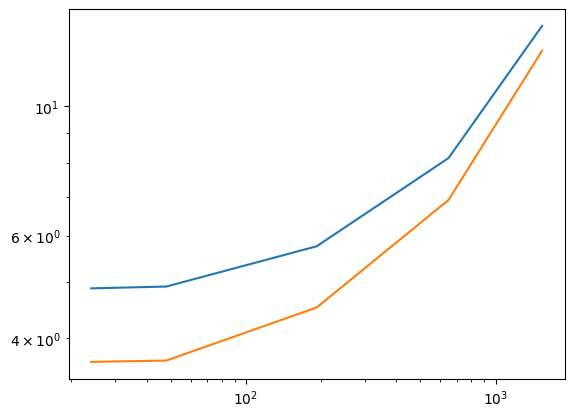

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = [24, 48, 192, 648,1536]
y1 = [4.868161678314209,4.903261184692383,5.749314069747925,8.150183200836182,13.746757745742798,]
y2 = [3.6398768424987793,3.659087181091308,4.513372421264648,6.905642509460449,12.45873475074768]

plt.loglog(x, y1, label="GPWNO_time")
plt.loglog(x, y2, label="GPWNO_time_wo_radius")
plt.show()

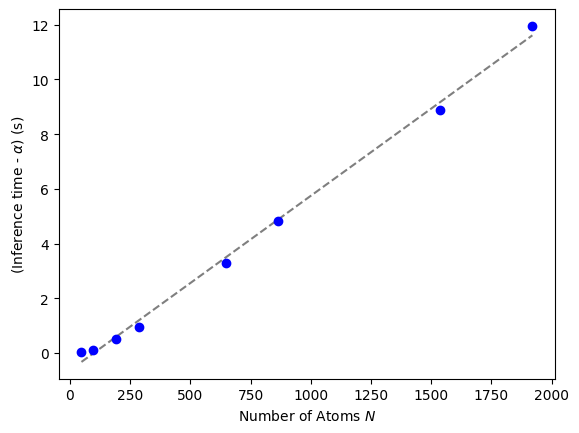

In [72]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.array([24, 48,96, 192, 288,648, 864, 1536,1920])
y1 = np.array([4.868161678314209,4.903261184692383,4.988894462585449, 5.387979507446289,5.8362298011779785,8.150183200836182,9.70795249938964,13.746757745742798,16.82429575920105])
# y2 = np.array([3.6398768424987793,3.659087181091308,3.7511518001556396,4.513372421264648, 4.591786861419678,6.905642509460449,8.455397129058838, 12.45873475074768,15.509971618652344])
y1 -= y1[0]
coef = np.polyfit(x[1:],y1[1:],1)
poly1d_fn = np.poly1d(coef)
# y2 -= y2[0]

# plt.loglog(x[1:], y1[1:], label="GPWNO_time", marker="o")
plt.plot(x[1:], poly1d_fn(x[1:]), '--k',alpha=0.5)
plt.plot(x[1:],y1[1:], 'bo') #'--k'=black dashed line, 'yo' = yellow circle marker
# plt.loglog(x, y1, label="GPWNO_time", marker="o")
# plt.loglog(x[1:], y2[1:], label="GPWNO_time_wo_radius",marker="s")
# plt.title("Number of Atoms vs. Inference time (GPWNO)")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Number of Atoms $N$")
plt.ylabel(f"(Inference time - $\\alpha)$ (s)")
plt.show()

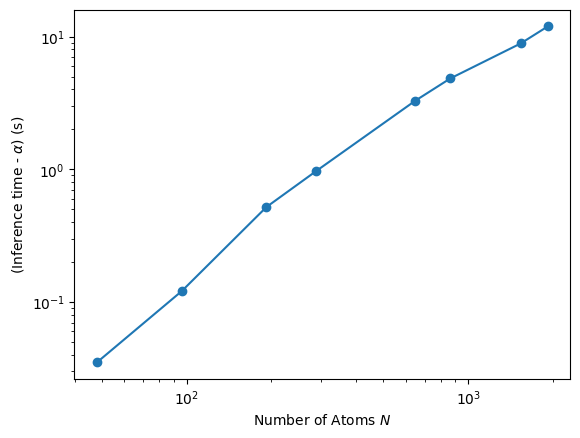

In [67]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.array([24, 48,96, 192, 288,648, 864, 1536,1920])
y_inf = np.array([4.868161678314209,4.903261184692383,4.988894462585449, 5.387979507446289,5.8362298011779785,8.150183200836182,9.70795249938964,13.746757745742798,16.82429575920105])
y_train = np.array([
    
])
y_inf -= y_inf[0]
coef = np.polyfit(x[1:],y_inf[1:],1)
poly1d_fn = np.poly1d(coef)
# y2 -= y2[0]

plt.loglog(x[1:], y_inf[1:], label="GPWNO_time", marker="o")
# plt.plot(x[1:], poly1d_fn(x[1:]), '--k',alpha=0.5)
# plt.plot(x[1:],y1[1:], 'bo') #'--k'=black dashed line, 'yo' = yellow circle marker
# plt.loglog(x, y1, label="GPWNO_time", marker="o")
# plt.loglog(x[1:], y2[1:], label="GPWNO_time_wo_radius",marker="s")
# plt.title("Number of Atoms vs. Inference time (GPWNO)")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Number of Atoms $N$")
plt.ylabel(f"(Inference time - $\\alpha)$ (s)")
plt.show()